# Named entity recognition with Bert PyTorch

Named Enity Recognition is one of the most common NLP problems. The goal is classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc. What can you use it for? Here are a few ideas - social media, chatbot, customer support tickets, survey responses, and data mining!

Let's start by importing some packages.

In [1]:
files_path = "./"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers

# Training Parameters
We'll set the hyperparameters for training our model.

In [3]:
# Hyperparams if GPU is available
if len(tf.config.list_physical_devices('GPU')) > 0:
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

# Data

Let's take a look at data. [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv)

In [4]:
data = pd.read_csv(f"{files_path}ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['B-per', 'I-art', 'I-gpe', 'B-art', 'O', 'I-per', 'B-geo', 'I-tim', 'I-nat', 'I-geo', 'B-nat', 'B-org', 'B-gpe', 'I-org', 'I-eve', 'B-tim', 'B-eve']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


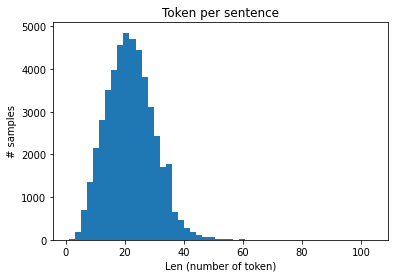

In [6]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

# Data Preprocessing
Before feeding the data into the model, we have to preprocess the text.

In [7]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

The sentences are annotated with the BIO-schema and the labels look like this.

In [8]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [9]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

### Prepare the sentences and labels

Before we can start fine-tuning the model, we have to prepare the data set for the use with pytorch and BERT.

In [ ]:
! pip install transformers

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

Using TensorFlow backend.


'1.5.1+cu101'

Here we fix some configurations. We will limit our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the Bert paper. Note, that Bert supports sequences of up to 512 tokens.

In [14]:
MAX_LEN = 75
bs = 32

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [16]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

The Bert implementation comes with a pretrained tokenizer and a definied vocabulary. We load the one related to the smallest pre-trained model bert-base-cased. We use the cased variate since it is well suited for NER.

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Now we tokenize all sentences. Since the BERT tokenizer is based a Wordpiece tokenizer it will split tokens in subword tokens. For example ‘gunships’ will be split in the two tokens ‘guns’ and ‘##hips’. We have to deal with the issue of splitting our token-level labels to related subtokens. In practice you would solve this by a specialized data structure based on label spans, but for simplicity I do it explicitly here.

In [18]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [19]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [20]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

Next, we cut and pad the token and label sequences to our desired length.

In [21]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [22]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

The Bert model supports something called attention_mask, which is similar to the masking in keras. So here we create the mask to ignore the padded elements in the sequences.

In [23]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

Now we split the dataset to use 10% to validate the model.

In [24]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

Since we’re operating in pytorch, we have to convert the dataset to torch tensors.



In [25]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

The last step is to define the dataloaders. We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.

In [26]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

The transformer package provides a BertForTokenClassification class for token-level predictions. BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel. The token-level classifier is a linear layer that takes as input the last hidden state of the sequence. We load the pre-trained bert-base-cased model and provide the number of possible labels.

In [27]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'3.0.2'

In [28]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Now we have to pass the model parameters to the GPU.

In [29]:
model.cuda();

Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. A common choice is the AdamW optimizer. We also add some weight_decay as regularization to the main weight matrices. If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed. This will still give you a good performance.

In [30]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

We also add a scheduler to linearly reduce the learning rate throughout the epochs.

In [31]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## Fit BERT for named entity recognition
First we define some metrics, we want to track while training. We use the f1_score from the seqeval package. You ca find more details here. And we use simple accuracy on a token level comparable to the accuracy in keras.

In [ ]:
! pip install seqeval

In [36]:
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange

Finally, we can finetune the model. A few epochs should be enougth. The paper suggest 3-4 epochs

In [37]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.1933022626186186
Validation loss: 0.1399431469043096
Validation Accuracy: 0.9564909507106039


Epoch:  33%|███▎      | 1/3 [06:12<12:25, 372.83s/it]

Validation F1-Score: 0.8059171597633136

Average train loss: 0.11022734615242066
Validation loss: 0.1297031193971634
Validation Accuracy: 0.9597598932859048


Epoch:  67%|██████▋   | 2/3 [12:24<06:12, 372.40s/it]

Validation F1-Score: 0.8224928582168095

Average train loss: 0.08266287265805247
Validation loss: 0.13044918569425742
Validation Accuracy: 0.961571397987583


Epoch: 100%|██████████| 3/3 [18:35<00:00, 371.89s/it]

Validation F1-Score: 0.8274398445673292



# Visualize the training loss

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


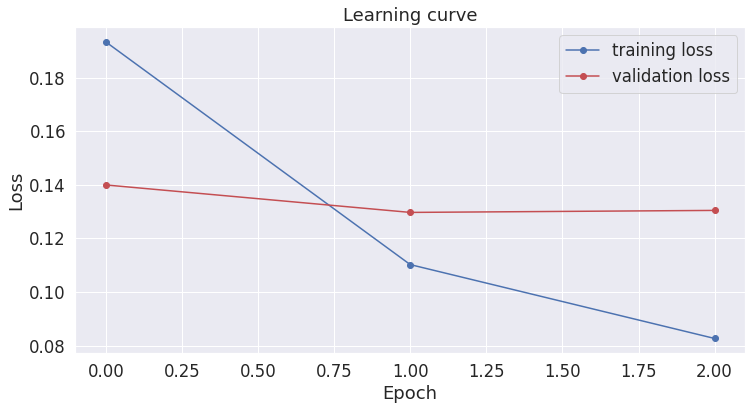

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Apply the model to a new sentence

Finally we want our model to identify named entities in new text. I just took this sentence from the recent New York Times frontpage.

In [40]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""

We first tokenize the text.

In [41]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

Then we can run the sentence through the model.

In [42]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [43]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [44]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
B-per	Mr
B-per	.
I-per	Trump
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	Fox
I-org	News
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]


this works amazing! This approach will give you very strong performing models for named entity recognition. Since BERT is available as a multilingual model in 102 languages, you can use it for a wide variety of tasks. Try it for your problems and let me know how it works for you.

# References

[Named entity recognition with Bert
](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/)

[Name Entity Recognition with BERT in TensorFlow](https://androidkt.com/name-entity-recognition-with-bert-in-tensorflow/)

[Transformers: State-of-the-art Natural Language Processing for Pytorch and TensorFlow 2.0.](https://github.com/huggingface/transformers)